In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
dataset = "blish_2020"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)
adata.raw.var.index = adata.raw.var['feature_name']
adata.var.index = adata.var['feature_name']
adata.obs['Azithromycin'] = ['Yes' if x in ['C1', 'C3', 'C4'] else 'No' for x in adata.obs['Donor.full']] 

## Some preprocessing for later displays

In [4]:
import pandas as pd
isg_list = pd.read_csv("../isg.list.csv")['gene']

sc.tl.score_genes(
    adata,
    isg_list,
    use_raw=False,
    score_name='IFN_score',
    random_state=42
)

HLA_list = []

for gene in adata.var.feature_name.values:
    if gene.startswith("HLA"):
        HLA_list.append(gene)

sc.tl.score_genes(
    adata,
    HLA_list,
    use_raw=False,
    score_name='HLA_score',
    random_state=42
)

/homes/gws/ewein/miniconda3/envs/contrastive-vi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Here we continue

In [5]:
target_adata = adata[adata.obs["disease"] != "normal"].copy()
background_adata = adata[adata.obs["disease"] == "normal"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

SCVI.setup_anndata(target_adata, layer="count")
SCVI.setup_anndata(target_trans_adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 28094 cells, 2000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 2

In [6]:
torch_device = "cuda:6"
seed = 123

contrastiveVI_model = torch.load(
    os.path.join(constants.DEFAULT_RESULTS_PATH, f"{dataset}/contrastiveVI/latent_10/{seed}/model.ckpt"),
    map_location=torch_device,
)

During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [7]:
from anndata import AnnData

salient_latent_representations = contrastiveVI_model.get_latent_representation(
    adata=target_adata,
    representation_kind="salient"
)
adata_salient = AnnData(X = salient_latent_representations, obs=target_adata.obs)

background_latent_representations = contrastiveVI_model.get_latent_representation(
    adata=target_adata,
    representation_kind="background"
)
adata_background = AnnData(X = background_latent_representations, obs=target_adata.obs)

In [8]:
from umap import UMAP

umap_background = UMAP(min_dist=0.5).fit_transform(adata_background.X)
umap_salient = UMAP(min_dist=0.5).fit_transform(adata_salient.X)

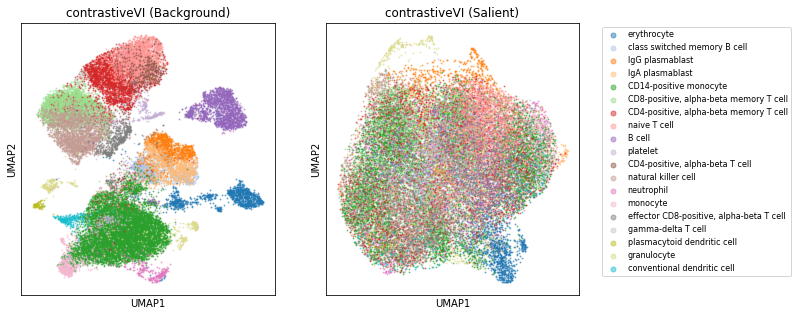

In [9]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

cell_type_labels = target_adata.obs["cell_type"]
admission_labels = target_adata.obs["Admission"]

for i, label in enumerate(cell_type_labels.unique()):
    ax2.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=0.5,
        color=cm.tab20(i)
    )
    
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
ax2.set_title("contrastiveVI (Salient)")

for i, label in enumerate(cell_type_labels.unique()):
    ax1.scatter(
        umap_background[:, 0][cell_type_labels == label],
        umap_background[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=0.5,
        color=cm.tab20(i)
    )
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("contrastiveVI (Background)")
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")

    
ax2.legend(markerscale=5, fontsize=8, loc='upper right', bbox_to_anchor=(1.85, 1))

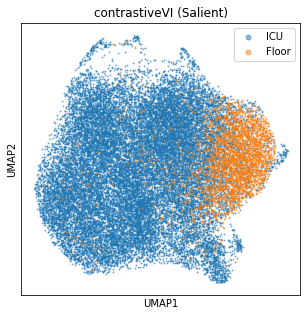

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

for i, label in enumerate(admission_labels.unique()):
    ax1.scatter(
        umap_salient[:, 0][admission_labels == label],
        umap_salient[:, 1][admission_labels == label],
        s=1,
        label=label,
        alpha=0.5,
    )
    
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title("contrastiveVI (Salient)")
ax1.legend(markerscale=5)

In [11]:
adata_salient_icu = adata_salient[adata_salient.obs['Admission'] == 'ICU']
umap_salient_icu = UMAP(min_dist=0.5).fit_transform(adata_salient_icu.X)

In [12]:
silhouette_score(umap_salient_icu, adata_salient_icu.obs['Ventilated'])

0.14777103

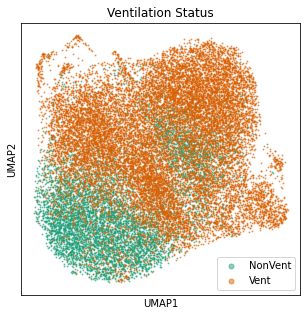

In [13]:
ventilated_labels = adata_salient_icu.obs["Ventilated"]
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

for i, label in enumerate(ventilated_labels.unique()):
    ax1.scatter(
        umap_salient_icu[:, 0][ventilated_labels == label],
        umap_salient_icu[:, 1][ventilated_labels == label],
        s=1,
        label=label,
        color=cm.Dark2(i),
        alpha=0.5,
    )
    
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title("Ventilation Status")
ax1.legend(markerscale=5)

In [14]:
def format_axis(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

NameError: name 'ax3' is not defined

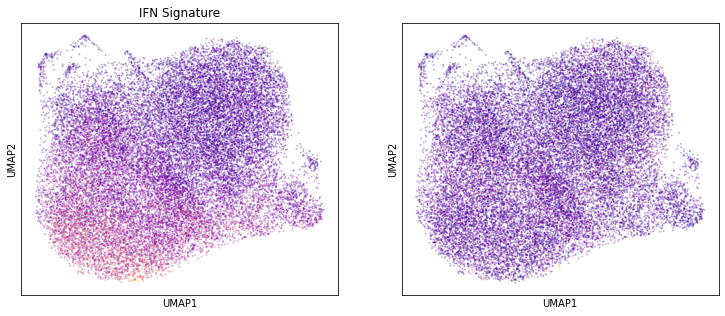

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5,5))
alpha = 0.25

s = ax1.scatter(
    umap_salient_icu[:, 0],
    umap_salient_icu[:, 1],
    s=1,
    alpha=alpha,
    c=adata_salient_icu.obs["IFN_score"],
    cmap='plasma'
)
format_axis(ax1)
ax1.set_title("IFN Signature")

s = ax2.scatter(
    umap_salient_icu[:, 0],
    umap_salient_icu[:, 1],
    s=1,
    alpha=alpha,
    c=adata_salient_icu.obs["HLA_score"],
    cmap='plasma'
)
format_axis(ax2)
ax3.set_title("HLA Class II Signature")

fig.colorbar(s, ax=(ax1, ax2))
plt.show()

In [ ]:
adata_salient_erythrocyte = adata_salient[adata_salient.obs['cell_type'] == 'erythrocyte']

In [ ]:
umap_erythrocyte = UMAP(min_dist=0.5).fit_transform(adata_salient_erythrocyte.X)

In [ ]:
from sklearn.cluster import KMeans
adata_salient_erythrocyte.obs['cluster_label'] = KMeans(n_clusters=2).fit(adata_salient_erythrocyte.X).labels_

In [ ]:
sc.pp.neighbors(adata_salient_erythrocyte, n_neighbors=15)
sc.tl.leiden(adata_salient_erythrocyte, resolution=0.155)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

for i, label in enumerate(adata_salient_erythrocyte.obs['leiden'].unique()):
    ax.scatter(
        umap_erythrocyte[:, 0][adata_salient_erythrocyte.obs['leiden'] == label],
        umap_erythrocyte[:, 1][adata_salient_erythrocyte.obs['leiden'] == label],
        s=10,
        label="Cluster {}".format(i),
        color=cm.tab20(i),
        alpha=0.5,
    )

ax.set_title("Leiden Clustering")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5,5))

label_key = "DPS"
s = ax1.scatter(
    umap_erythrocyte[:, 0],
    umap_erythrocyte[:, 1],
    s=10,
    label=label,
    c=adata_salient_erythrocyte.obs[label_key],
    alpha=0.5,
)

ax1.set_title("Days Post Symptom Onset")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")

label_key = "DTF"
s = ax2.scatter(
    umap_erythrocyte[:, 0],
    umap_erythrocyte[:, 1],
    s=10,
    label=label,
    c=adata_salient_erythrocyte.obs[label_key],
    alpha=0.5,
)

ax2.set_title("Days from First Reported Fever")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
fig.colorbar(s, ax=(ax1, ax2))

In [ ]:
from typing import Dict, Iterable, Optional, Sequence, Union
from scvi._compat import Literal
from scvi.model.base._utils import _de_core
from scvi.model._utils import _get_var_names_from_setup_anndata,  scrna_raw_counts_properties
from anndata import AnnData
from functools import partial


Number = Union[int, float]

def get_normalized_expression(
    adata: Optional[AnnData] = None,
    indices: Optional[Sequence[int]] = None,
    transform_batch: Optional[Sequence[Union[Number, str]]] = None,
    gene_list: Optional[Sequence[str]] = None,
    library_size: Union[float, Literal["latent"]] = 1,
    n_samples: int = 1,
    n_samples_overall: int = None,
    batch_size: Optional[int] = None,
    return_mean: bool = True,
    return_numpy: Optional[bool] = None,
):
    exprs = contrastiveVI_model.get_normalized_expression(
        adata=adata,
        indices=indices,
        transform_batch=transform_batch,
        gene_list=gene_list,
        library_size=library_size,
        n_samples=n_samples,
        n_samples_overall=n_samples_overall,
        batch_size=batch_size,
        return_mean=return_mean,
        return_numpy=return_numpy,
    )
    return exprs["salient"]

model_fn = partial(
    get_normalized_expression,
    return_numpy=True,
    n_samples=100,
    batch_size=128,
)
erythrocyte_adata = target_adata[target_adata.obs['cell_type'] == 'erythrocyte']
erythrocyte_adata.obs['leiden'] = adata_salient_erythrocyte.obs['leiden']
col_names = _get_var_names_from_setup_anndata(target_adata)
result = _de_core(
    erythrocyte_adata,
    model_fn,
    groupby="leiden",
    group1="0",
    group2="1",
    idx1=None,
    idx2=None,
    all_stats=True,
    all_stats_fn=scrna_raw_counts_properties,
    col_names=col_names,
    mode="change",
    batchid1=None,
    batchid2=None,
    delta=0.25,
    batch_correction=False,
    fdr=0.05,
    silent=False,
)

In [ ]:
result = result.sort_values(by="proba_de", ascending=False)

In [ ]:
top_genes = result[result["proba_de"] > 0.95].index.tolist()

In [ ]:
import gseapy as gp

enr = gp.enrichr(
    gene_list=top_genes,
    gene_sets="KEGG_2019_Human",
    organism="human"
)

enr_results = enr.results

In [ ]:
enr_results